In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from pathlib import Path
ROOT = Path('.')
gdrive = ROOT/'gdrive'/'My Drive'/'247'

list(gdrive.iterdir())

[PosixPath('gdrive/My Drive/247/.gitignore'),
 PosixPath('gdrive/My Drive/247/data_explore.ipynb'),
 PosixPath('gdrive/My Drive/247/GCN2.ipynb'),
 PosixPath('gdrive/My Drive/247/CS247_pre.gslides'),
 PosixPath('gdrive/My Drive/247/GCN_copy.ipynb'),
 PosixPath('gdrive/My Drive/247/data_original'),
 PosixPath('gdrive/My Drive/247/data'),
 PosixPath('gdrive/My Drive/247/GCN.ipynb')]

In [0]:
import os
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.optim as optim

import numpy as np
import pandas as pd
import argparse
import scipy.sparse as sp
import pickle
import easydict
from sklearn.preprocessing import normalize
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt

In [0]:
class GraphConvolution(Module):
    """
    Simple rGCN layer, similar to https://arxiv.org/abs/1703.06103
    :param num_relation: number of different relations in the data
    :param num_neighbors: a #relation x #node x 1 matrix that denotes number of neighbors of a node in a relation
    :param in_features: number of feature of the input
    :param out_features: number of feature of the ouput
    :param bias: if bias is added, default is True
    :type num_relation: int
    :type num_relation: int
    :type num_neighbors: array-like object, must be 3 dimension
    :type in_features: int
    :type out_features: int
    :type bias: bool
    """

    def __init__(self, num_relation, num_neighbors, in_features, out_features, num_child, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.adj_weight = Parameter(nn.init.kaiming_uniform_(torch.FloatTensor(num_relation, in_features, out_features)))
        self.num_neighbors = num_neighbors
        self.feature_weight = Parameter(nn.init.kaiming_uniform_(torch.FloatTensor(in_features, out_features)))
        self.attention = Parameter(nn.init.uniform_(torch.FloatTensor(num_relation)))
        self.importance = Parameter(nn.init.uniform_(torch.FloatTensor(num_child), -1.0, 1.0))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.adj_weight.size(2))
        # self.weight.data.uniform_(-stdv, stdv)
        # self.adj_weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adjs, idx = None):
        outputs = []
        num_node = adjs[0].shape[0]
        if idx is not None:
            cur_importance = torch.reshape(torch.sigmoid(self.importance[idx]), (-1,1))
        else:
            cur_importance = torch.reshape(torch.sigmoid(self.importance), (-1, 1))
        for i in range(len(self.adj_weight)):
            support = torch.mm(input, self.adj_weight[i])
            support = cur_importance * support
            output = torch.spmm(adjs[i], support)
#             output = output / self.num_neighbors[i]
            output = output * F.softmax(self.attention, dim=0)[i]
            outputs.append(output)
        output = sum(outputs)
#         output = self.normalization(outputs)
        # feature_out = torch.mm(input, self.feature_weight)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def normalization(self, embedding: list) -> torch.Tensor:
        relations = []
        total_sum = 0.0
        for emb in embedding:
            relations.append(torch.sum(emb, dim=0))
        total_sum = sum(relations)
        relations = [relation / total_sum for relation in relations]

        # print(f"relation size {len(relations)}")

        relation_normalization = 0
        outputs = 0
        if embedding[0].device == 'cuda':
            relation_normalization = torch.stack(relations, dim=0).cuda()
            outputs = torch.stack(embedding, dim=0).cuda()
        else:
            relation_normalization = torch.stack(relations, dim=0)
            outputs = torch.stack(embedding, dim=0)
        assert type(relation_normalization) == torch.Tensor
        assert type(outputs) == torch.Tensor

        attention = []
        for i in range(embedding[0].size(1)):
            attention.append(self.attention)
        attention = torch.stack(attention, dim=1)
        attention = F.softmax(attention * relation_normalization, dim=0).reshape(len(embedding), 1, embedding[0].size(1))
        outputs = attention * outputs
        return torch.sum(outputs, dim=0)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [0]:
class rGCN(nn.Module):
    def __init__(self, num_relation, nfeat, nhid, nclass, dropout, num_people, num_device):
        super(rGCN, self).__init__()

        self.gc1 = GraphConvolution(num_relation, None, nfeat, nhid, num_people)
        self.gc2 = GraphConvolution(num_relation, None, nhid, nhid, num_device)
        self.final_pred_weight1 = Parameter(nn.init.kaiming_uniform_(torch.FloatTensor(21396, nhid)))
        self.final_pred_weight2 = Parameter(nn.init.kaiming_uniform_(torch.FloatTensor(2 * nhid, nclass)))
        self.dropout = dropout

        
    def forward(self, x, extra_fea, adjs1, adjs2, idx):
        x = F.relu(self.gc1(x, adjs1, idx))
        x = F.dropout(x, 0.4, training=self.training)
        extra_out = F.dropout(F.relu(torch.spmm(extra_fea, self.final_pred_weight1)),self.dropout, training=self.training)
        x_out = self.gc2(x, adjs2, None)
        x_out =torch.cat([x_out, extra_out], 1)
        final_out = torch.mm(x_out, self.final_pred_weight2)
        return F.log_softmax(final_out, dim=1)

In [0]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def plot_confusion_matrix(y_true, output, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, filename = None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    y_pred = output.max(1)[1].type_as(y_true)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=6.5)
    fig.tight_layout()
    if filename:
        np.save(filename + '.npy', cm)
        fig.savefig(filename + '.png')
    return ax

def top_k_accuracy(output, labels, k):
    pred = torch.topk(output, k, dim=1)[1].type_as(labels)
    correct = pred.eq(labels.view(-1, 1).expand_as(pred)).double()
    correct = correct.sum()
    return correct / len(labels)

In [0]:
def train(data, model, optimizer, epoch):
#     features, adjs, idx_train, idx_val, labels = data
    [adjs, adjs_T, train_idx, test_idx, train_wapp_idx, device_applabel, labels] = data
    
    active, installed = adjs
    active_T, installed_T = adjs_T
    best_test = 0
    for i in range(epoch):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        l1_act = sparse_mx_to_torch_sparse_tensor(active_T[:, train_idx])
        l1_ins = sparse_mx_to_torch_sparse_tensor(installed_T[:, train_idx])
        l2_act = sparse_mx_to_torch_sparse_tensor(active[train_idx])
        l2_ins = sparse_mx_to_torch_sparse_tensor(installed[train_idx])
        extra_fea = sparse_mx_to_torch_sparse_tensor(device_applabel[train_idx])
        
        if torch.cuda.is_available():
            l1_act = l1_act.cuda(0)
            l2_act = l2_act.cuda(0)
            l1_ins = l1_ins.cuda(0)
            l2_ins = l2_ins.cuda(0)
            extra_fea = extra_fea.cuda(0)
            labels = labels.cuda(0)

        adj1 = [l1_act, l1_ins]
        adj2 = [l2_act, l2_ins]
        
        
        features = F.one_hot(labels[train_idx]).float()
        cur_label = labels[train_idx]


        output = model(features, extra_fea, adj1, adj2, train_wapp_idx)
        loss_train = F.nll_loss(output, cur_label)
        acc_train = accuracy(output, cur_label)
        loss_train.backward()
        optimizer.step()
        print('Epoch: {:04d}'.format(i+1), 'loss_train: {:.4f}'.format(loss_train.item()), 'acc_train: {:.4f}'.format(acc_train.item()),'time: {:.4f}s'.format(time.time() - t))   
        if i % 5 == 0 or i == (epoch - 1):
            if i == epoch -1:
                plot_cm = True
            else:
                plot_cm = False
            test_acc = test([adjs, adjs_T, train_idx, test_idx, device_applabel, labels], model, plot_cm)
            if test_acc > best_test:
                best_test = test_acc
                DATA = 'gdrive/My Drive/247/data'
                print('save model current best acc {}'.format(best_test))
                torch.save(model.state_dict(), os.path.join(DATA,'best_model.pth'))


In [0]:
def test(data, model, plot_confusion =False):
    [adjs, adjs_T, train_idx, test_idx, device_applabel, labels] = data
    active, installed = adjs
    active_T, installed_T = adjs_T
    l1_act = sparse_mx_to_torch_sparse_tensor(active_T[:, train_idx])
    l1_ins = sparse_mx_to_torch_sparse_tensor(installed_T[:, train_idx])
    l2_act = sparse_mx_to_torch_sparse_tensor(active[test_idx])
    l2_ins = sparse_mx_to_torch_sparse_tensor(installed[test_idx])
    extra_fea = sparse_mx_to_torch_sparse_tensor(device_applabel[test_idx])
    
    if torch.cuda.is_available():
        l1_act = l1_act.cuda(0)
        l2_act = l2_act.cuda(0)
        l1_ins = l1_ins.cuda(0)
        l2_ins = l2_ins.cuda(0)
        extra_fea = extra_fea.cuda(0)
        labels = labels.cuda(0)
    
    adj1 = [l1_act, l1_ins]
    adj2 = [l2_act, l2_ins]
    features = F.one_hot(labels[train_idx]).float()
    test_label = labels[test_idx]
     
    model.eval()
    output = model(features, extra_fea, adj1, adj2, train_idx)
    loss_test = F.nll_loss(output, test_label)
    acc_test = accuracy(output, test_label)
    acc_k_test = top_k_accuracy(output, test_label, 3)
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()),
          "accuracy@3= {:.4f}".format(acc_k_test.item()))
    
    classes = unique_labels(labels)
    
    if plot_confusion:
        plot_confusion_matrix(test_label, output, classes, normalize=True)
    return acc_test.item()

In [0]:
def calculate_laplacian(adj):
    total_nodes = adj.shape[0]
    adj = adj + sp.identity(total_nodes)
    degree = adj.sum(axis=1)
    degree_sqrt_inv = np.sqrt(1.0 / degree).reshape(1, -1)
    D_sqrt_inv = sp.diags(degree_sqrt_inv, [0], shape=(total_nodes, total_nodes))
    adj_tilde = np.dot(np.dot(D_sqrt_inv, adj), D_sqrt_inv)
    return adj_tilde

In [0]:

def main():

    args = easydict.EasyDict({
        "epochs": 1,
        "lr": 0.001,
        "weight_decay": 1e-5,
        "hidden": 96,
        "dropout": 0.2
    })

    CUDA = torch.cuda.is_available()
    np.random.seed(42)
    torch.manual_seed(42)
    if CUDA:
        torch.cuda.manual_seed(42)

    DATA = 'gdrive/My Drive/247/data'
    
    # active is in the shape of (peole, device); active_T is in the shape of (device, people)
    active = sp.load_npz(os.path.join(DATA, 'active.npz'))
    active_T = active.transpose()
    active_T = normalize(active_T, norm='l1', axis=1)
    installed = sp.load_npz(os.path.join(DATA, 'installed.npz'))
    installed_T = installed.transpose()
    installed_T = normalize(installed_T, norm='l1', axis=1)  
    
    device_applabel = sp.load_npz(os.path.join(DATA, 'active_wapplabel.npz'))
   
    adjs = [active, installed]
    adjs_T = [active_T, installed_T]
    
    train_idx = np.load(os.path.join(DATA, 'train_idx.npy'))
    test_idx = np.load(os.path.join(DATA,'test_idx.npy'))
    train_wapp_idx = np.load(os.path.join(DATA, 'train_idx.npy')) # this is the data we used to propagate label out, we originally tried to use just those user with app information but then we find use all the data give us better results 
    labels = np.load(os.path.join(DATA,'label.npy'))
    labels = torch.LongTensor(labels)

    rGCN_model = rGCN(len(adjs),
                12, # the first layer input is just one-hot embedding of the 12 classes
                args.hidden,
                labels.max().item() + 1,
                args.dropout, active.shape[0], active.shape[1])
    if os.path.exists(os.path.join(DATA,'best_model.pth')):
        rGCN_model.load_state_dict(torch.load(os.path.join(DATA,'best_model.pth')))
    optimizer = optim.Adam(rGCN_model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)

    
    if CUDA:
        rGCN_model.cuda(0)
    print("start training")
    train([adjs, adjs_T, train_idx, test_idx,train_wapp_idx, device_applabel, labels], rGCN_model, optimizer, args.epochs)

start training
Epoch: 0001 loss_train: 1.9810 acc_train: 0.3102 time: 1.8784s
Test set results: loss= 2.3709 accuracy= 0.2024 accuracy@3= 0.4605
Normalized confusion matrix
save model current best acc 0.20235782704802732


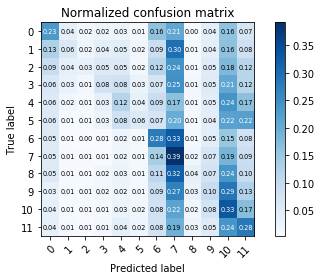

In [41]:
main()